In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../Database/kp_classify_blur.csv')
df.head()

,match,image_tag,pos,point_x,point_y,size,angle,response,octave,blur
0,0,S6722S03,right-side,45,111,31.000000,28.460091,0.000393,0,11.132859
1,0,S6735S09,right-side,53,118,44.640003,8.228042,0.000368,2,19.968516
2,0,S6722S03,left-side,46,131,44.640003,169.835007,0.000731,2,11.132859
3,0,S6735S09,left-side,42,75,37.200001,2.890326,0.000027,1,19.968516
4,0,S6722S03,left-side,32,74,31.000000,215.737335,0.000347,0,11.132859


In [3]:
# dividing the datasets into two parts i.e. training datasets and test datasets
mapping = {'right-side': 0, 'left-side': 1, 'bottom': 2, 'complete': 3}
df['pos'] = df['pos'].map(mapping)

df = df.sample(n=650000, random_state=42).reset_index(drop=True)
# df = df.drop(['angle', 'response', 'octave'], axis=1)

y = df['match']
X = df.drop(labels=['match', 'image_tag'], axis=1)

print(X)

print(y[:2])
print(X[:2])

        pos  point_x  point_y       size       angle  response  octave  \
0         2       77       52  31.000000  211.736313  0.005257       0   
1         0       45       74  31.000000  295.463562  0.000104       0   
2         3      122      162  31.000000   78.733017  0.000667       0   
3         0       71      135  31.000000  148.699371  0.000192       0   
4         2       97       61  31.000000   92.807922  0.000259       0   
...     ...      ...      ...        ...         ...       ...     ...   
649995    2      112       55  37.200001   96.287933  0.001798       1   
649996    2      138       56  31.000000   25.741657  0.001881       0   
649997    2       84       51  44.640003  124.883850  0.001365       2   
649998    3      125      192  31.000000  100.930305  0.002873       0   
649999    3       75      100  37.200001  217.164230  0.000652       1   

              blur  
0        20.372345  
1         8.541138  
2        16.364299  
3        10.694818  
4     

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [5]:
def RandomForest(X_train, X_test, y_train, y_test, parameters = {'n_estimators': 100,
                                     'max_depth': None,
                                     'max_features': 'sqrt',
                                     'criterion': 'gini',
                                     'bootstrap': True,
                                     'class_weight' : "balanced",
                                     'max_samples': None
                                     }):
    clf = RandomForestClassifier(n_estimators = 100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test) 

    # using metrics module for accuracy calculation
    accuracy = metrics.accuracy_score(y_test, y_pred)
    feature_imp = pd.Series(clf.feature_importances_, index = X.keys()).sort_values(ascending = False)
    return accuracy, feature_imp, clf

In [7]:
def XGBoost(X_train, X_test, y_train, y_test, model_path='xgboost_model.json'):
    # Initialize MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))

    # Fit and transform the training data, transform the test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled data to DMatrix format (optimized for XGBoost)
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test)

    # Set XGBoost parameters
    params = {
        'objective': 'binary:logistic',  # Binary classification
        'eval_metric': 'auc',  # Evaluation metric, AUC is a common choice
        'eta': 0.1,  # Learning rate
        'max_depth': 10,  # Maximum depth of a tree
        'min_child_weight': 1,  # Minimum sum of instance weight (hessian) needed in a child
        'subsample': 0.8,  # Subsample ratio of the training instances
        'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
        'lambda': 1,  # L2 regularization term on weights
        'alpha': 0,  # L1 regularization term on weights
        'seed': 42  # Random seed for reproducibility
    }

    # Train the model
    bst = xgb.train(params, dtrain, num_boost_round=10000, evals=[(dtest, 'test')], early_stopping_rounds=50, verbose_eval=10)

    # Predict
    y_pred = bst.predict(dtest)
    predictions = [1 if x > 0.5 else 0 for x in y_pred]

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, y_pred)

    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc:.4f}')

    # Save the model
    bst.save_model(model_path)

    # Return the model and metrics
    return bst, accuracy, auc

# loaded_model = xgb.Booster()
# loaded_model.load_model('xgboost_model.json')

In [ ]:
bst, accuracy, auc = XGBoost(X_train, X_test, y_train, y_test)

In [9]:
print(accuracy, auc)

0.6643282051282051 0.7035754378986239


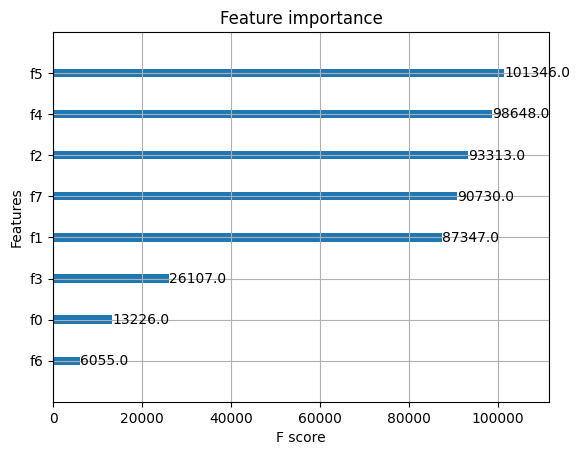

In [10]:
plot_importance(bst)
plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier

# # Define the model
# model = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# # Define hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }

# # Grid Search
# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best parameters
# print(f"Best parameters found: {grid_search.best_params_}")